In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import roc_curve,auc,roc_auc_score
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False


In [3]:
df=pd.read_excel(r'C:/Users/tian/Desktop/chengdudata.xlsx',index_col=0)
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,jinjiang,莲花,2室1厅,60.4平米,东,简装,低楼层(共6层),修建年限未知,板楼,67万,"11,093元/平"
1,jinjiang,合江亭,3室1厅,55.74平米,南,简装,低楼层(共7层),修建年限未知,板塔结合,100万,"17,941元/平"
2,jinjiang,东湖,3室1厅,89.06平米,东南,精装,中楼层(共32层),2011年建,塔楼,万,"参考价:28,297元/平"
3,jinjiang,三官堂,3室2厅,89.41平米,西,精装,高楼层(共34层),2011年建,板塔结合,267万,"29,863元/平"
4,jinjiang,卓锦城,3室1厅,62.43平米,东南,精装,中楼层(共29层),2015年建,塔楼,万,"参考价:28,845元/平"


In [4]:
df.rename(columns={0:'区',1:'小区',2:'房间数',3:'面积',4:'朝向',5:'装修情况',6:'所处楼层',7:'修建年限',8:'楼属性',9:'总价',10:'每平方米价'},inplace=True)

In [5]:
temp=['jinjiang','qingyang','wuhou','gaoxin7','chenghua','jinniu','tianfuxinqu','gaoxinxi1','shuangliu','wenjiang','pidou','longquanyi','xindou','tianfuxinqunanqu','qingbaijiang','doujiangyan','pengzhou','jianyang','xinjin','chongzhou1','dayi','jintang','pujiang','qionglai']
temps=['锦江','青羊','武侯','高新','成华','金牛','天府新区','高新西','双流','温江','郫都','龙泉驿','新都','天府新区南区','青白江','都江堰','彭州','简阳','新津','崇州','大邑','金堂','蒲江','邛崃']
dfs=[]

for j in df['区']:
    for i in range(len(temp)):
        if j==temp[i]:
            i=temps[i]
            dfs.append(i)

df['区']=dfs


In [6]:
df['总价']=df['总价'].apply(lambda x: '面议' if x=='万' else x)

In [7]:
df['面积']=df['面积'].apply(lambda x: x.replace('平米',''))

In [8]:
df['所处楼层']=df['所处楼层'].apply(lambda x: x[:3])

In [9]:
df2=df.query('所处楼层 == "中楼层" or 所处楼层 == "高楼层" or 所处楼层=="低楼层"')

In [10]:
# 2 特征编码
x=df2
def make_code(x):
    tag={'高楼层':1,
        '中楼层':2,
        '低楼层':3}
    key=x['所处楼层']
    return tag.get(key)
df2['楼层得分']=df2.apply(make_code,axis=1)

C:\Users\tian\AppData\Local\Temp/ipykernel_4408/2727042109.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['楼层得分']=df2.apply(make_code,axis=1)


In [11]:
xs=df2
def make_codes(xs):
    tags={'其他':1,
        '毛胚':2,
        '简装':4,
        '精装':6}
    keys=xs['装修情况']
    return tags.get(keys)
df2['装修得分']=df2.apply(make_codes,axis=1)

C:\Users\tian\AppData\Local\Temp/ipykernel_4408/178891322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['装修得分']=df2.apply(make_codes,axis=1)


In [12]:
xss=df2
def make_codess(xss):
    tagss={'1室0厅':0.5,
        '1室1厅':1,
        '1室2厅':1.5,
        '2室0厅':2,
        '2室1厅':2.5,
        '2室2厅':3,
        '3室0厅':3.5,
        '3室1厅':4,
        '3室2厅':4.5,
        '3室3厅':5,
        '4室1厅':5.5,
        '4室2厅':6,
        '4室3厅':6.5,
        '5室1厅':7,
        '5室2厅':7.5,
        '5室3厅':8,
        '6室2厅':9}
    keyss=xss['房间数']
    return tagss.get(keyss)
df2['房间数得分']=df2.apply(make_codess,axis=1)

C:\Users\tian\AppData\Local\Temp/ipykernel_4408/790845384.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['房间数得分']=df2.apply(make_codess,axis=1)


In [13]:
df2=df2.drop(columns=['房间数'])

In [14]:
ts=df2
def make_c(ts):
    tss={'暂无数据':1,
        '板楼':2,
        '板塔结合':3,
        '塔楼':4,
        '平房':5}
    kss=ts['楼属性']
    return tss.get(kss)
df2['楼属性得分']=df2.apply(make_c,axis=1)

In [15]:
df2=df2.drop(columns=['楼属性'])

In [16]:
df2

,区,小区,面积,朝向,装修情况,所处楼层,修建年限,总价,每平方米价,楼层得分,装修得分,房间数得分,楼属性得分
0,锦江,莲花,60.4,东,简装,低楼层,修建年限未知,67万,"11,093元/平",3,4.0,2.5,2
1,锦江,合江亭,55.74,南,简装,低楼层,修建年限未知,100万,"17,941元/平",3,4.0,4.0,3
2,锦江,东湖,89.06,东南,精装,中楼层,2011年建,面议,"参考价:28,297元/平",2,6.0,4.0,4
3,锦江,三官堂,89.41,西,精装,高楼层,2011年建,267万,"29,863元/平",1,6.0,4.5,3
4,锦江,卓锦城,62.43,东南,精装,中楼层,2015年建,面议,"参考价:28,845元/平",2,6.0,4.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55635,邛崃,三圣乡,47.2,西南,精装,高楼层,2011年建,102万,"21,611元/平",1,6.0,2.5,3
55636,邛崃,三官堂,57.61,东,简装,高楼层,2009年建,118万,"20,483元/平",1,4.0,1.5,3
55637,邛崃,三圣乡,76.48,东北,精装,低楼层,2011年建,155万,"20,267元/平",3,6.0,4.0,3
55638,邛崃,三圣乡,64.1,西北,简装,低楼层,2015年建,119万,"18,565元/平",3,4.0,2.5,4


In [18]:
df3=df2[df2['总价']!='面议']
df3

,区,小区,面积,朝向,装修情况,所处楼层,修建年限,总价,每平方米价,楼层得分,装修得分,房间数得分,楼属性得分
0,锦江,莲花,60.4,东,简装,低楼层,修建年限未知,67万,"11,093元/平",3,4.0,2.5,2
1,锦江,合江亭,55.74,南,简装,低楼层,修建年限未知,100万,"17,941元/平",3,4.0,4.0,3
3,锦江,三官堂,89.41,西,精装,高楼层,2011年建,267万,"29,863元/平",1,6.0,4.5,3
5,锦江,静居寺,128.25,南,简装,低楼层,2007年建,280万,"21,833元/平",3,4.0,4.0,2
7,锦江,卓锦城,75.44,西南,精装,低楼层,2012年建,155万,"20,547元/平",3,6.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55633,邛崃,静居寺,68.99,西南,简装,中楼层,2011年建,141万,"20,438元/平",2,4.0,2.5,4
55635,邛崃,三圣乡,47.2,西南,精装,高楼层,2011年建,102万,"21,611元/平",1,6.0,2.5,3
55636,邛崃,三官堂,57.61,东,简装,高楼层,2009年建,118万,"20,483元/平",1,4.0,1.5,3
55637,邛崃,三圣乡,76.48,东北,精装,低楼层,2011年建,155万,"20,267元/平",3,6.0,4.0,3


In [28]:
df4=df3[['面积','楼层得分','装修得分','房间数得分','楼属性得分','总价']]
df4.reset_index(inplace=True)

In [36]:
df4['总价']=df4['总价'].apply(lambda x:float(x.replace('万','')))

C:\Users\tian\AppData\Local\Temp/ipykernel_4408/3410999721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['总价']=df4['总价'].apply(lambda x:float(x.replace('万','')))


In [39]:
df4.drop('index',axis=1,inplace=True)

e:\python3.9\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [43]:
df4

,面积,楼层得分,装修得分,房间数得分,楼属性得分,总价
0,60.4,3,4.0,2.5,2,67.0
1,55.74,3,4.0,4.0,3,100.0
2,89.41,1,6.0,4.5,3,267.0
3,128.25,3,4.0,4.0,2,280.0
4,75.44,3,6.0,3.0,3,155.0
...,...,...,...,...,...,...
41558,68.99,2,4.0,2.5,4,141.0
41559,47.2,1,6.0,2.5,3,102.0
41560,57.61,1,4.0,1.5,3,118.0
41561,76.48,3,6.0,4.0,3,155.0


In [58]:
df4.fillna(1,inplace=True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41563 entries, 0 to 41562
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   面积      41563 non-null  object 
 1   楼层得分    41563 non-null  int64  
 2   装修得分    41563 non-null  float64
 3   房间数得分   41563 non-null  float64
 4   楼属性得分   41563 non-null  int64  
 5   总价      41563 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 1.9+ MB


e:\python3.9\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [59]:
y=df4['总价']

In [60]:
x=df4.drop('总价',axis=1)


In [61]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3)

In [100]:
rfc=RandomForestRegressor()
rfc=rfc.fit(xtrain,ytrain)

result=rfc.score(xtest,ytest)
result

0.9993485590567989

In [81]:
df4['面积']=df4['面积'].apply(lambda x:float(x))
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41563 entries, 0 to 41562
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   面积      41563 non-null  float64
 1   楼层得分    41563 non-null  int64  
 2   装修得分    41563 non-null  float64
 3   房间数得分   41563 non-null  float64
 4   楼属性得分   41563 non-null  int64  
 5   总价      41563 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.9 MB


C:\Users\tian\AppData\Local\Temp/ipykernel_4408/198479029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['面积']=df4['面积'].apply(lambda x:float(x))


In [86]:
temp=df4.corr()
temp

,面积,楼层得分,装修得分,房间数得分,楼属性得分,总价
面积,1.000000,0.048568,0.028363,0.768568,-0.017671,0.844361
楼层得分,0.048568,1.000000,0.008360,0.015112,0.075373,0.091157
装修得分,0.028363,0.008360,1.000000,0.026825,0.162836,0.081737
房间数得分,0.768568,0.015112,0.026825,1.000000,-0.079485,0.582644
楼属性得分,-0.017671,0.075373,0.162836,-0.079485,1.000000,0.131622
总价,0.844361,0.091157,0.081737,0.582644,0.131622,1.000000


<AxesSubplot:>

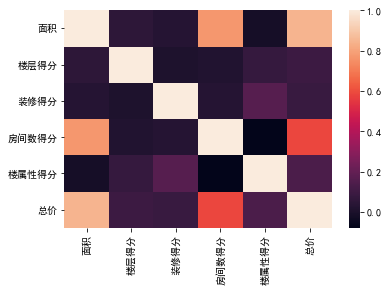

In [88]:
sns.heatmap(temp)

In [98]:
rfc.feature_importances_ 

array([0.87525591, 0.01799104, 0.02394582, 0.036888  , 0.04591923])

In [97]:
imt=rfc.feature_importances_  
for i in  zip(df4.columns[:-1],imt):
    print(i)

('面积', 0.8752559127303298)
('楼层得分', 0.017991042532621765)
('装修得分', 0.023945817916917)
('房间数得分', 0.036888000092826626)
('楼属性得分', 0.045919226727304835)


In [68]:
rfc.predict([[55,2,5,4,3]])

array([110.94002741])